#Importing Necessary Libraries

In [26]:
# Install required libraries and import all necessary modules
# Ultralytics for YOLO training, OpenCV for image processing,
# NumPy for array operations, and Google Drive for dataset access.

In [78]:
import os
import cv2
import glob
import random
import numpy as np
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import Image as DisplayImage, display

In [28]:
!pip install ultralytics

In [29]:
# Mount Google Drive to access dataset files stored in MyDrive
# and list directories for verification.

In [30]:
from google.colab import drive
from ultralytics import YOLO
from IPython.display import Image, display
import glob

In [31]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!ls "/content/drive/MyDrive"

'archive (1).zip'  'Copy of archive (1).zip'   merged_dataset
'Colab Notebooks'   extracted_archive


In [33]:
# Extract the provided MRI dataset ZIP file into a new folder
# to prepare for merging and training.

In [34]:
!unzip -o "/content/drive/MyDrive/archive (1).zip" -d "/content/drive/MyDrive/extracted_archive/"


Archive:  /content/drive/MyDrive/archive (1).zip
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/axial_t1wce_2_class.yaml  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_101.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_109.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_111.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_117.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_121.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_126.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00018_134.jpg  
  inflating: /content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/test/00019_66.jpg  
  inflating: /content/drive/MyDrive

In [35]:
!ls "/content/drive/MyDrive/extracted_archive"

axial_t1wce_2_class  coronal_t1wce_2_class  sagittal_t1wce_2_class


In [36]:
# Create separate folders for combined images and labels
# where all modalities (axial, coronal, sagittal) will be stored together.

In [37]:
!ls "/content/drive/MyDrive/extracted_archive/axial_t1wce_2_class"
!ls "/content/drive/MyDrive/extracted_archive/coronal_t1wce_2_class"
!ls "/content/drive/MyDrive/extracted_archive/sagittal_t1wce_2_class"

axial_t1wce_2_class.yaml  images  labels
coronal_t1wce_2_class.yaml  images  labels
images	labels	sagittal_t1wce_2_class.yaml


In [38]:
!mkdir -p /content/drive/MyDrive/merged_dataset/images
!mkdir -p /content/drive/MyDrive/merged_dataset/labels


In [39]:
# Copy dataset images and labels from axial, coronal, and sagittal
# folders into the unified merged_dataset/images and merged_dataset/labels.

In [40]:
# Axial
!cp -r "/content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/images/"* "/content/drive/MyDrive/merged_dataset/images/"
!cp -r "/content/drive/MyDrive/extracted_archive/axial_t1wce_2_class/labels/"* "/content/drive/MyDrive/merged_dataset/labels/"

# Coronal
!cp -r "/content/drive/MyDrive/extracted_archive/coronal_t1wce_2_class/images/"* "/content/drive/MyDrive/merged_dataset/images/"
!cp -r "/content/drive/MyDrive/extracted_archive/coronal_t1wce_2_class/labels/"* "/content/drive/MyDrive/merged_dataset/labels/"

# Sagittal
!cp -r "/content/drive/MyDrive/extracted_archive/sagittal_t1wce_2_class/images/"* "/content/drive/MyDrive/merged_dataset/images/"
!cp -r "/content/drive/MyDrive/extracted_archive/sagittal_t1wce_2_class/labels/"* "/content/drive/MyDrive/merged_dataset/labels/"


^C


In [41]:
# Create a YAML configuration file for YOLO training.
# Defines train/test directories, number of classes, and class names.

In [56]:
yaml_content = """
train: /content/drive/MyDrive/merged_dataset/images/train
val: /content/drive/MyDrive/merged_dataset/images/test

nc: 2
names: ["negative", "positive"]
"""
with open("/content/drive/MyDrive/merged_dataset/merged_data.yaml", "w") as f:
    f.write(yaml_content)


In [57]:
# Delete unused or empty 'val' folders to avoid training errors.

In [58]:
!rm -r /content/drive/MyDrive/merged_dataset/images/val
!rm -r /content/drive/MyDrive/merged_dataset/labels/val


rm: cannot remove '/content/drive/MyDrive/merged_dataset/images/val': No such file or directory
rm: cannot remove '/content/drive/MyDrive/merged_dataset/labels/val': No such file or directory


In [59]:
# Perform an 80-20 random split of images into train and test folders.
# Ensures YOLO receives properly structured dataset directories.

In [60]:
# Paths
dataset_path = "/content/drive/MyDrive/merged_dataset/images"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Create train/test folders
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# List all image files in the main dataset folder
images = [f for f in os.listdir(dataset_path)
          if f.endswith((".jpg", ".png", ".jpeg"))
          and os.path.isfile(os.path.join(dataset_path, f))]

if not images:
    print("No images found in dataset folder!")
else:
    # Shuffle images
    random.shuffle(images)

    # Split 80% train, 20% test
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Move images to train/test folders
    for f in train_images:
        shutil.move(os.path.join(dataset_path, f), os.path.join(train_path, f))

    for f in test_images:
        shutil.move(os.path.join(dataset_path, f), os.path.join(test_path, f))

    print(f"Train images: {len(train_images)}, Test images: {len(test_images)}")


No images found in dataset folder!


In [61]:
# Load YOLO11n pre-trained model and begin training with custom dataset.
# Trains for 60 epochs with batch size 10 and 640x640 input resolution.


In [62]:
# Load pre-trained YOLOv8 small model
model = YOLO("yolo11n.pt")

# Train the model
results = model.train(
    data="/content/drive/MyDrive/merged_dataset/merged_data.yaml",
    epochs=60,
    imgsz=640,
    batch=10
)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/merged_dataset/merged_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

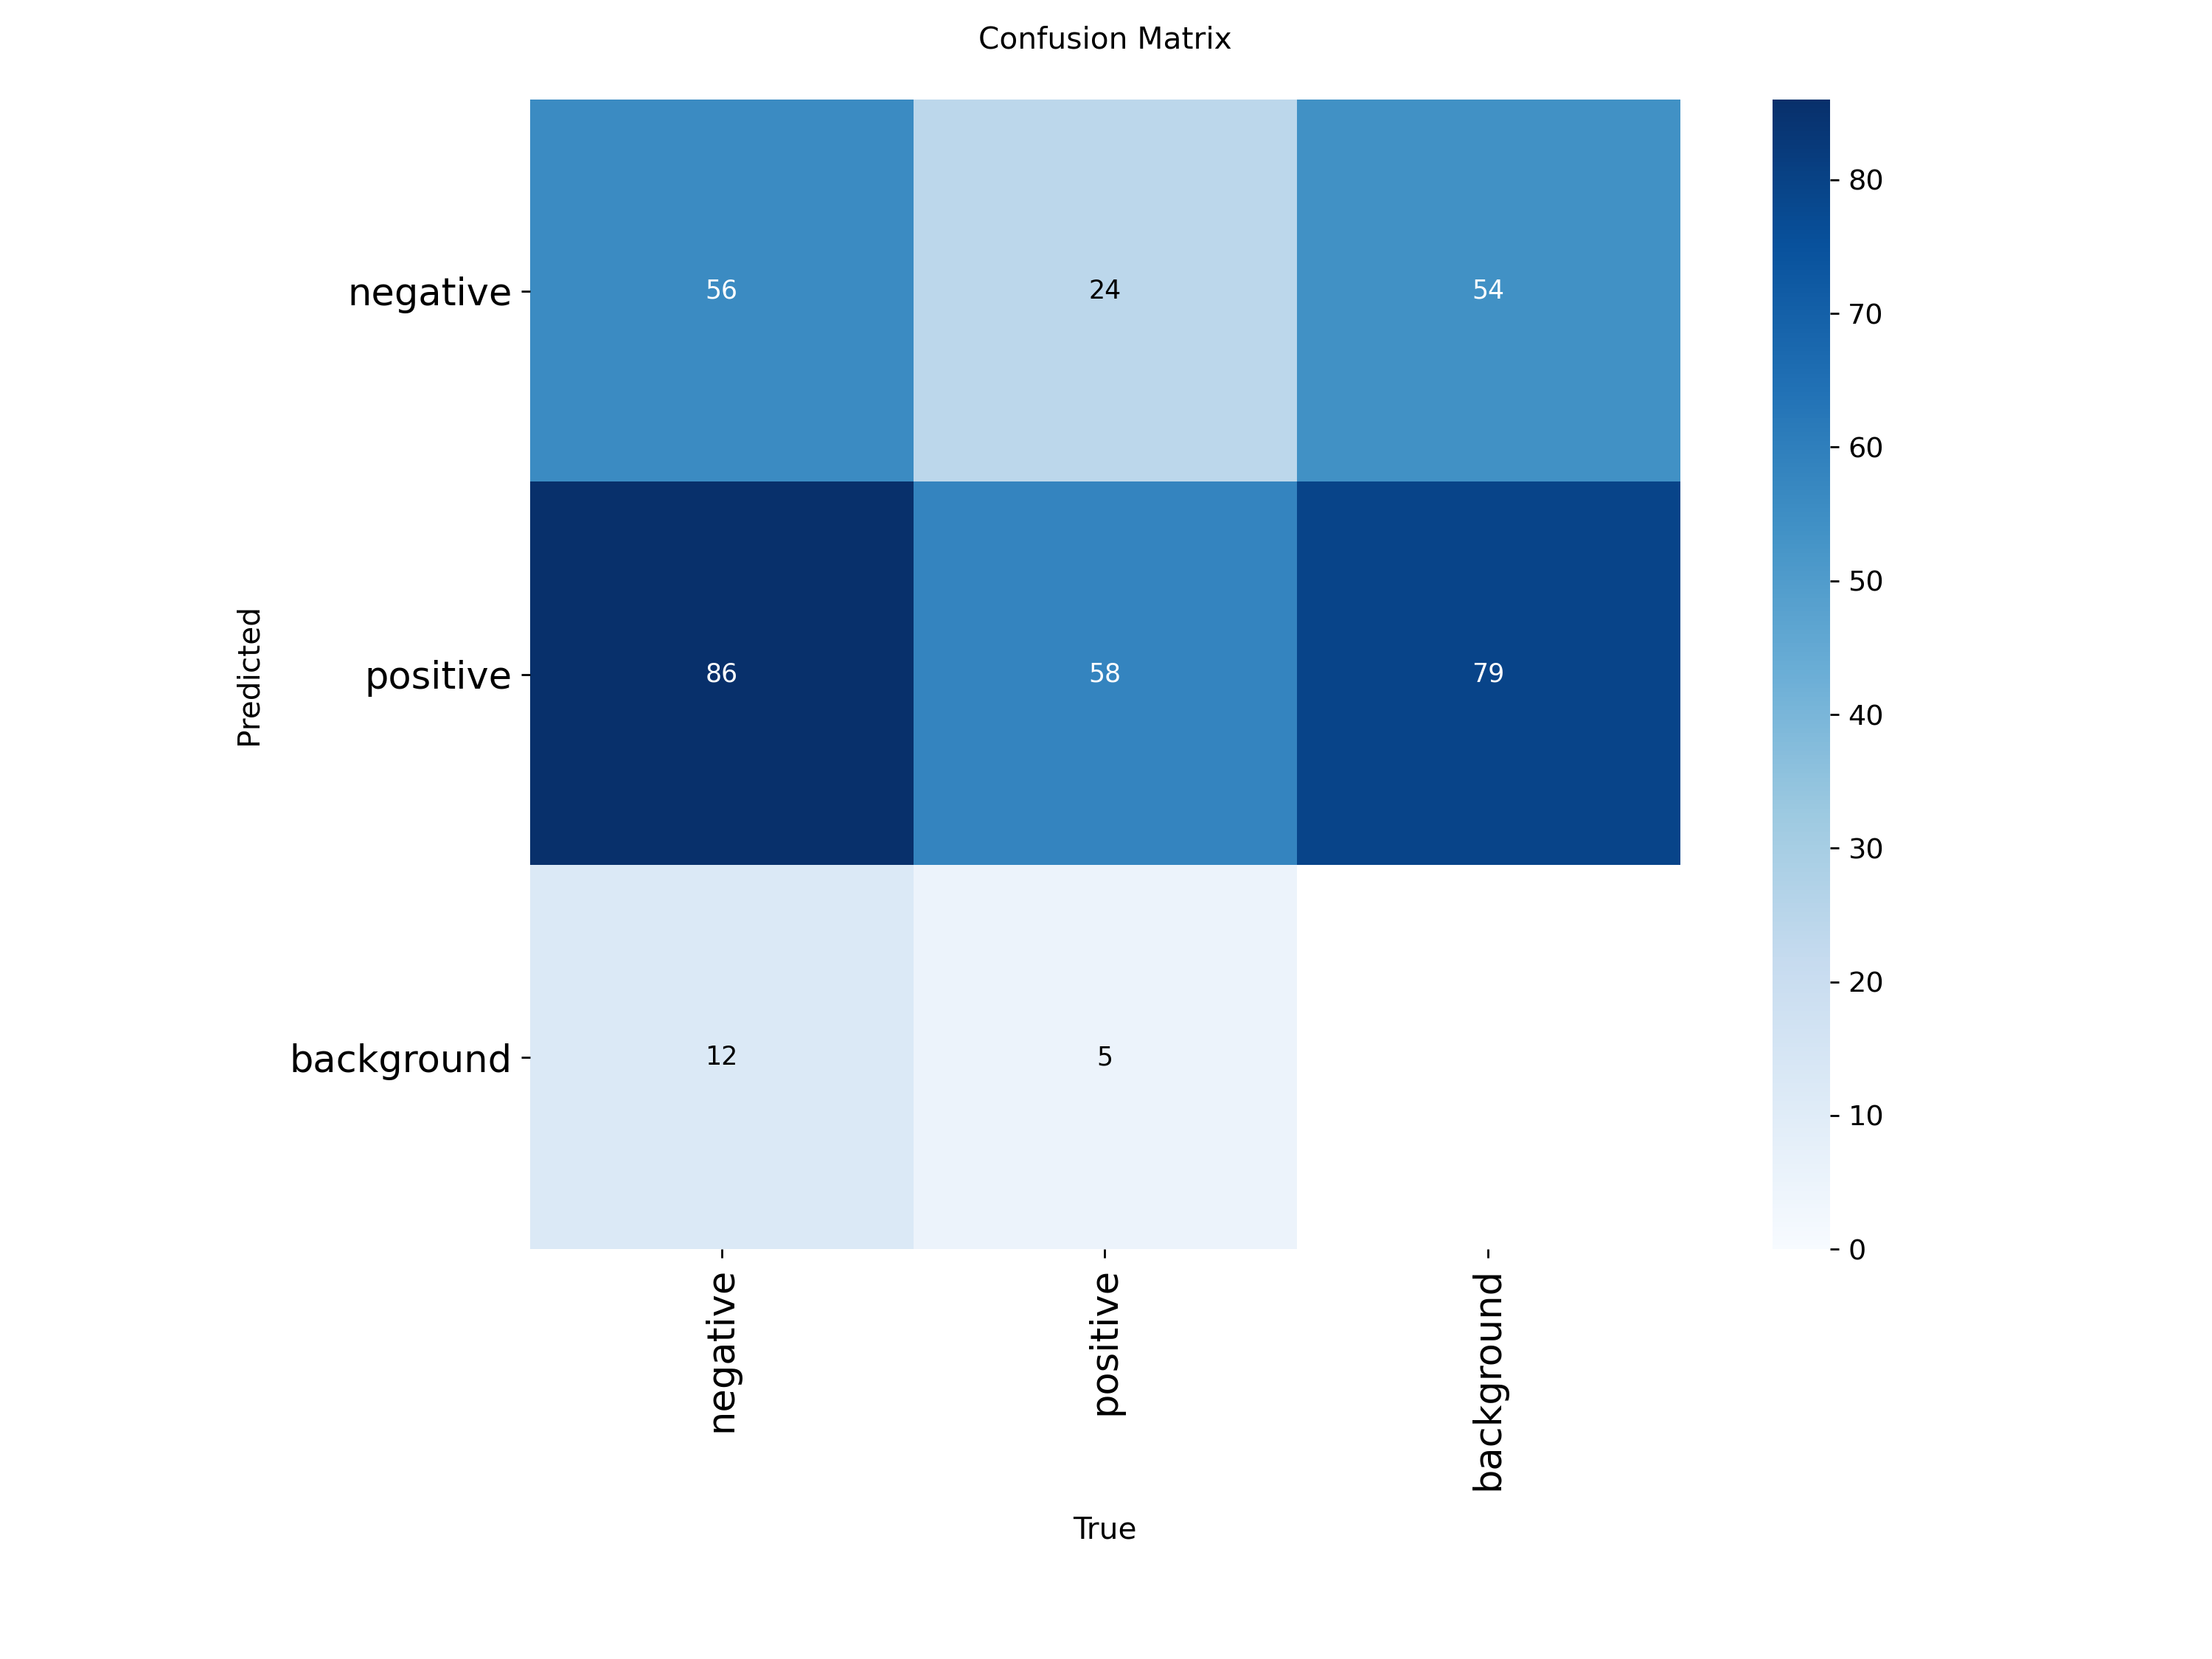

In [68]:
#Display Confusion Matrix
display(Image("/content/runs/detect/train4/confusion_matrix.png"))

In [63]:
# Display the last 10 predicted sample images from training results
# to visually confirm the model’s performance.

In [64]:
# Get list of all predicted images (adjust extension if needed)
predicted_images = glob.glob("/content/runs/detect/train7/*.jpg")

# Display last 10 predicted images
for img_path in predicted_images[-10:]:
    display(Image(filename=img_path))


In [65]:
# Full prediction pipeline:
# - Run YOLO prediction
# - Apply green mask overlay
# - Draw bounding boxes using random colors
# - Display class names and confidence scores
# - Save output images for review


image 1/1 /content/runs/detect/train4/train_batch0.jpg: 640x640 1 negative, 1 positive, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


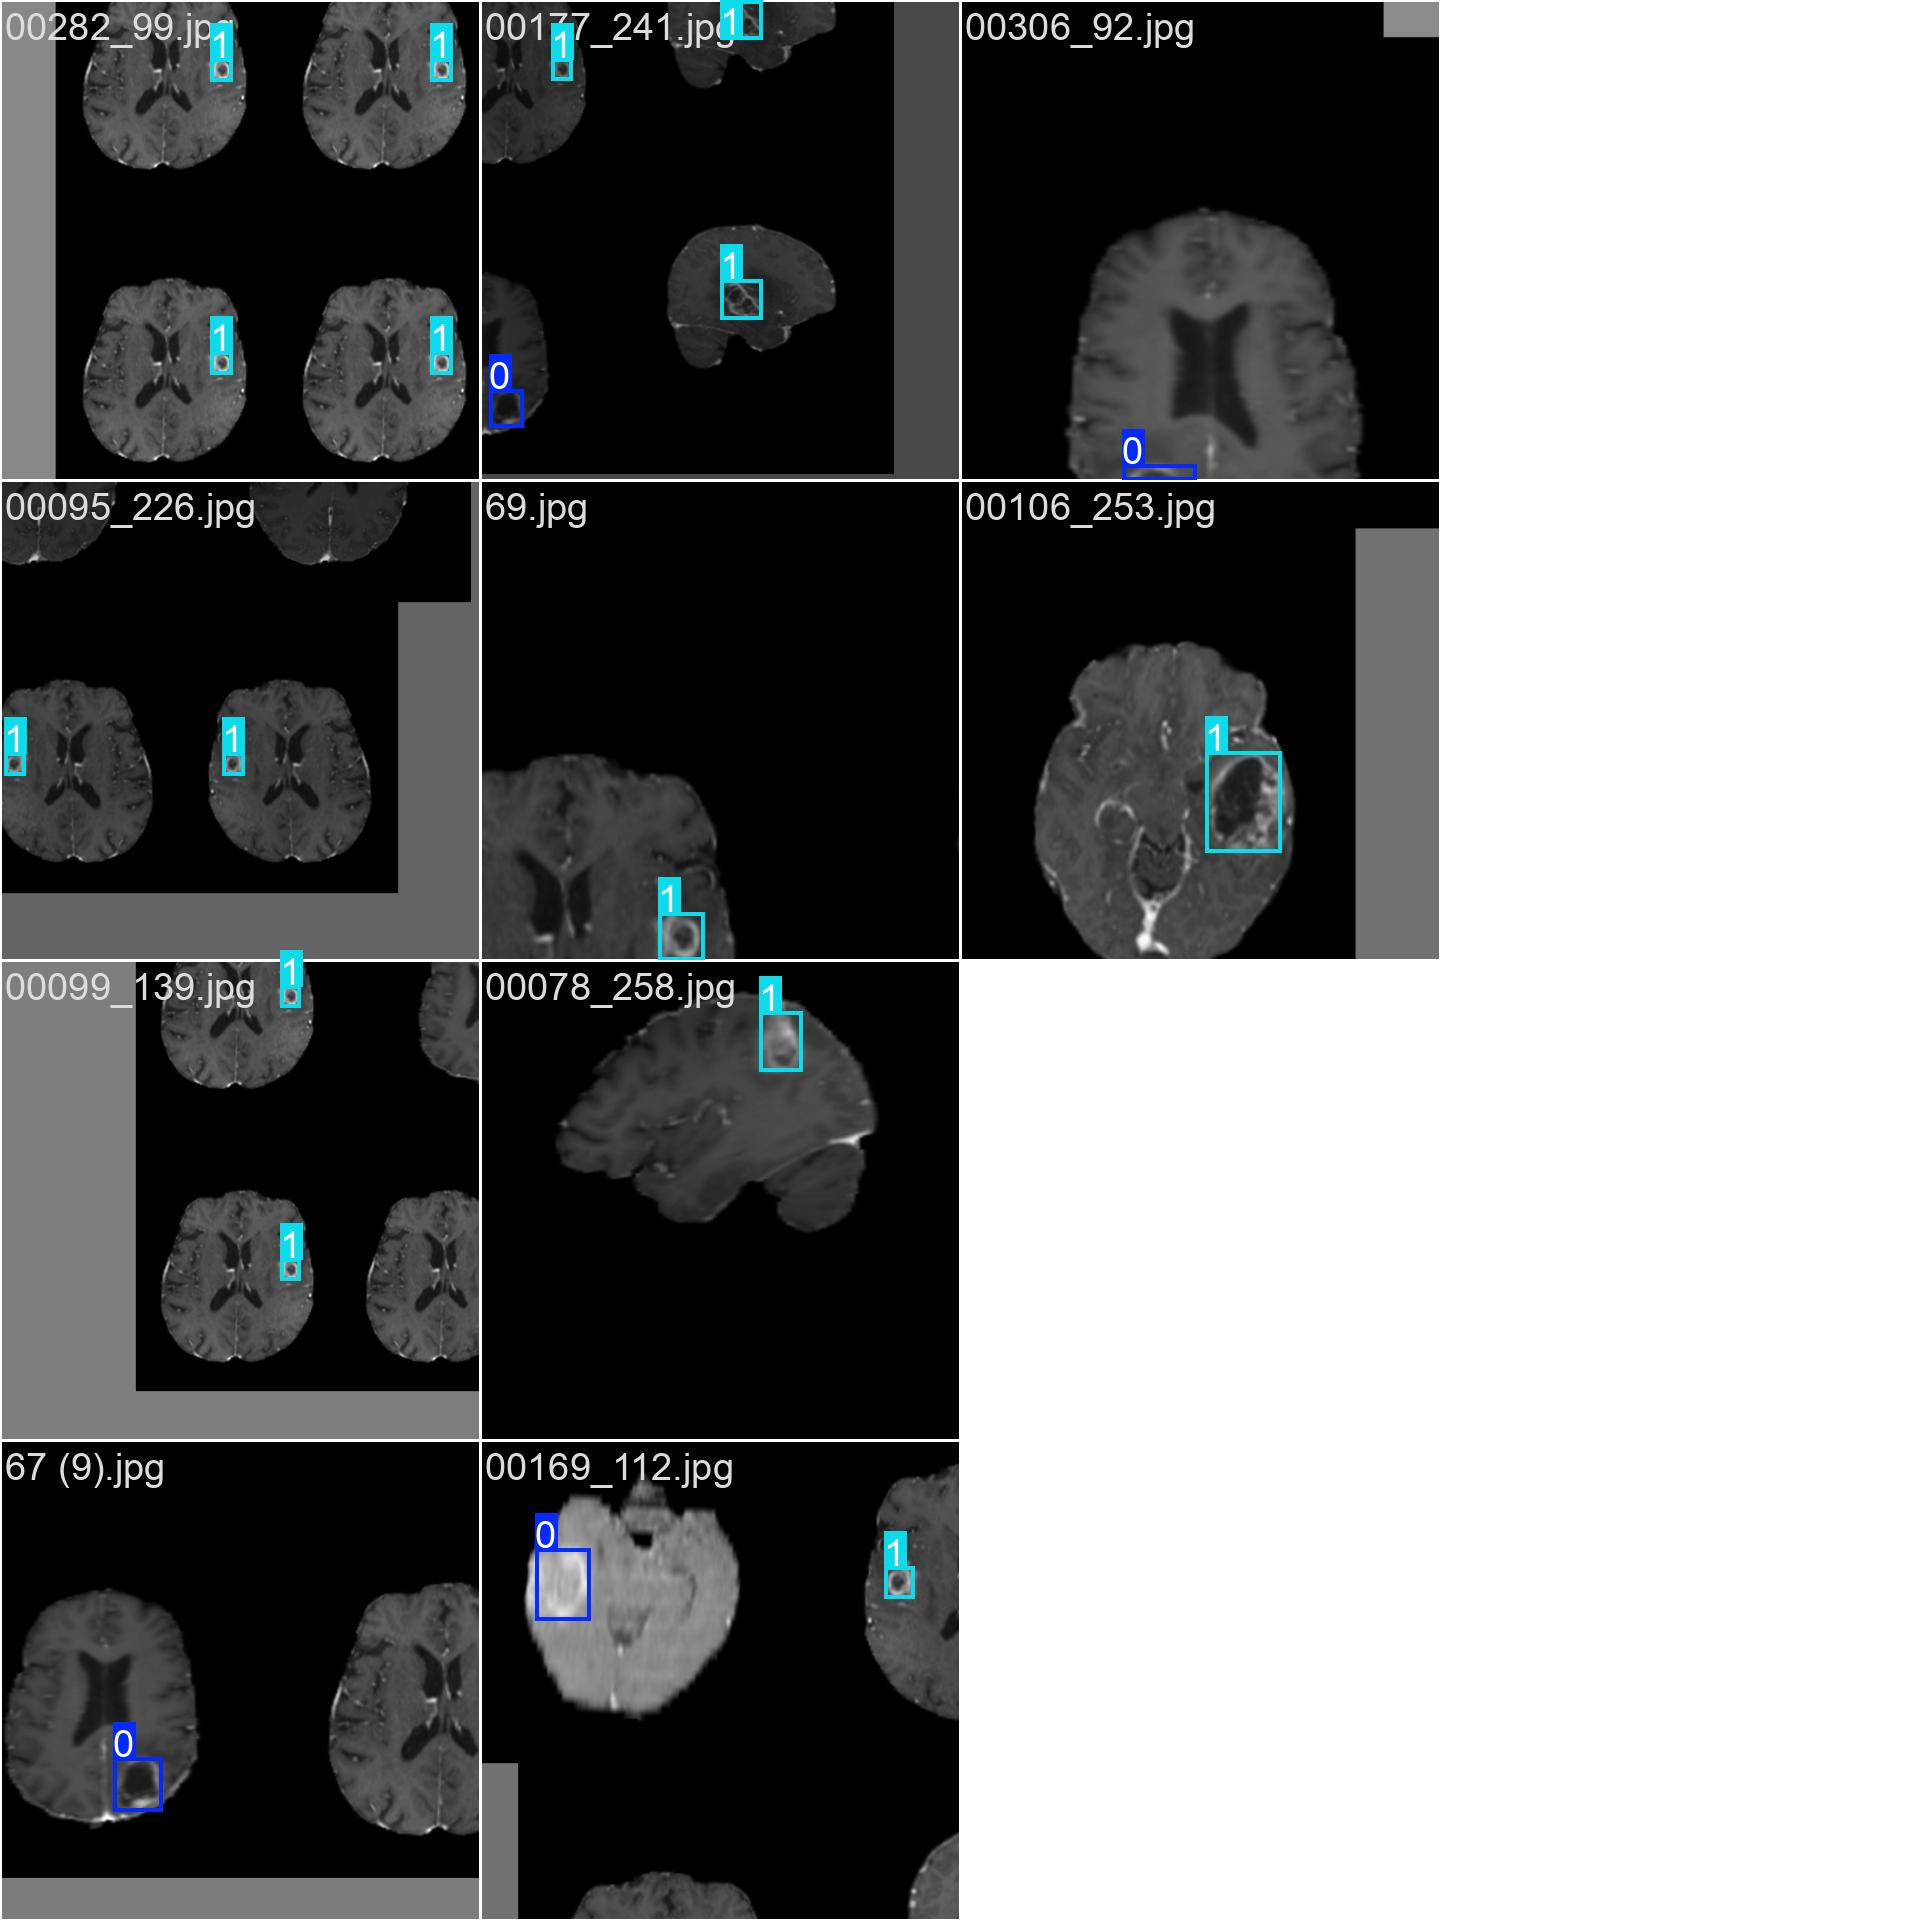

In [72]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# Load model
model = YOLO("/content/runs/detect/train4/weights/best.pt")

# Image path
img_path = "/content/runs/detect/train4/train_batch0.jpg"

# Read & preprocess image
img = cv2.imread(img_path)

# Inference
results = model(img_path)[0]

# Show image properly
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(Image.fromarray(rgb_image))


In [73]:
# Execute prediction pipeline on random images from the test set.
# Prints detected classes and bounding box details for verification.


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/57 (4).jpg: 640x640 1 positive, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


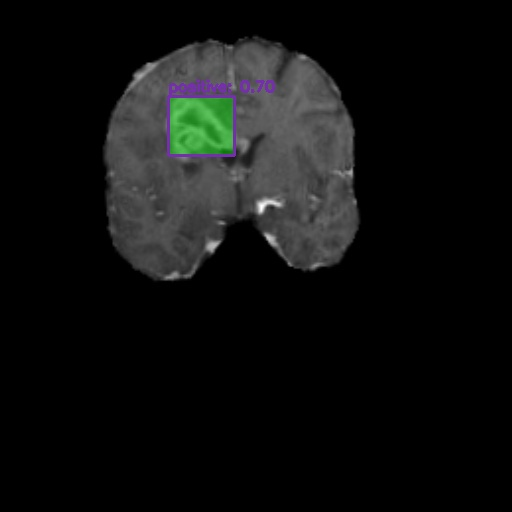


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/44.jpg: 640x640 1 negative, 44.6ms
Speed: 7.8ms preprocess, 44.6ms inference, 11.7ms postprocess per image at shape (1, 3, 640, 640)


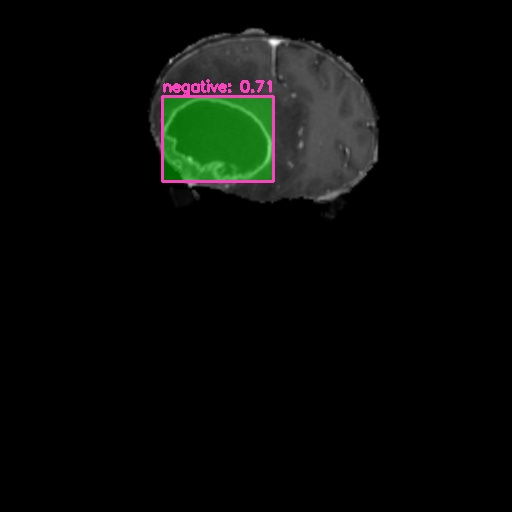


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/60 (8).jpg: 640x640 1 positive, 22.4ms
Speed: 7.5ms preprocess, 22.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


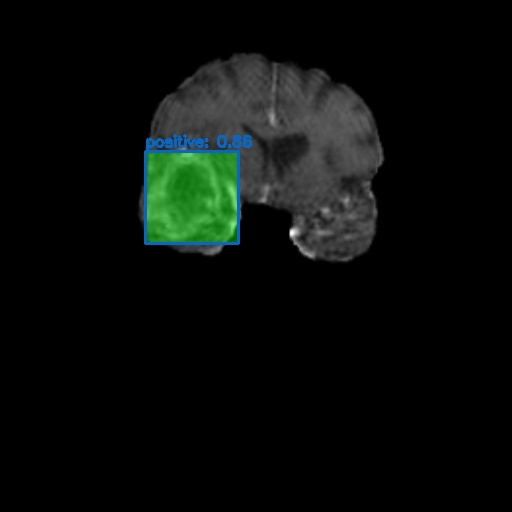


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00084_130.jpg: 640x640 2 positives, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


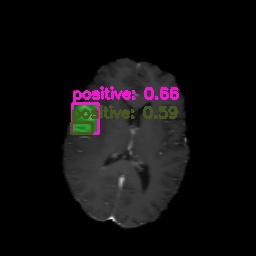


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/58 (4).jpg: 640x640 2 positives, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


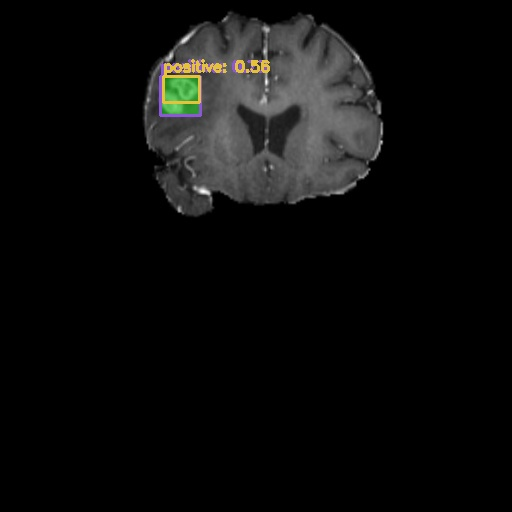


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00053_263.jpg: 640x640 1 positive, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


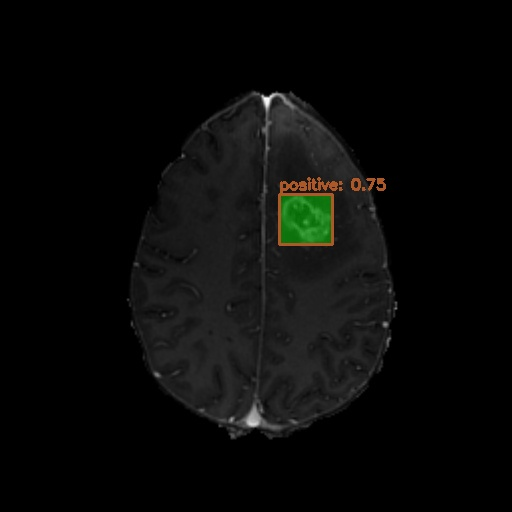


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00088_150.jpg: 640x640 1 positive, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


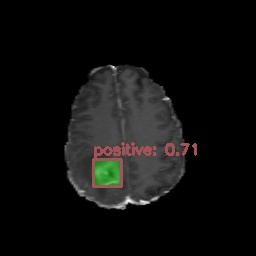


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00031_273.jpg: 640x640 1 positive, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


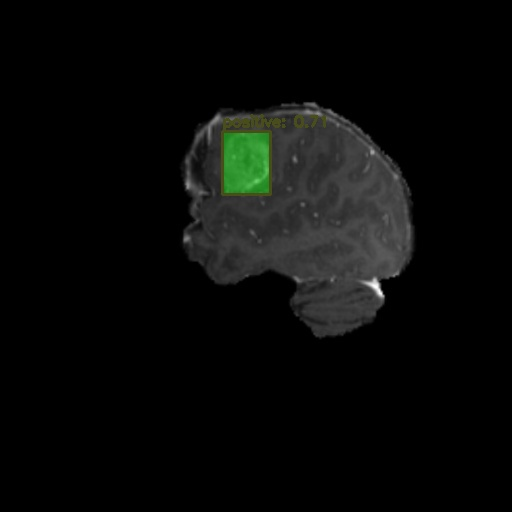


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00044_111.jpg: 640x640 1 positive, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


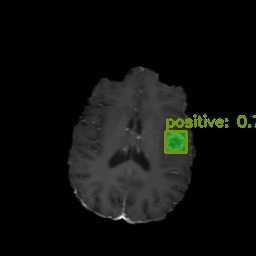


image 1/1 /content/drive/MyDrive/merged_dataset/images/test/00002_129.jpg: 640x640 1 positive, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


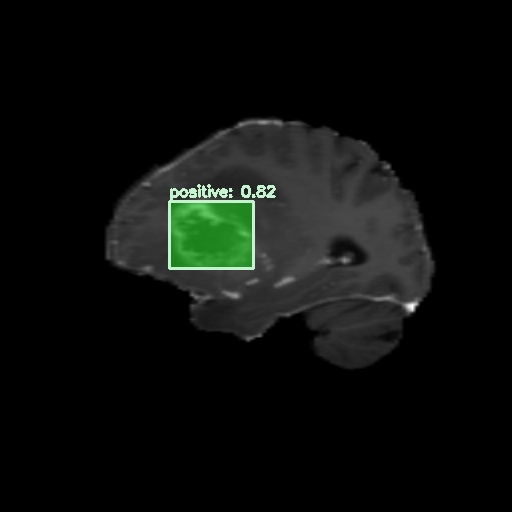

/content/drive/MyDrive/merged_dataset/images/test/57 (4).jpg
Boxes: [[      168.2      96.865      234.25      155.17]]
Classes: ['positive']
--------------------------------------------------
/content/drive/MyDrive/merged_dataset/images/test/44.jpg
Boxes: [[     162.78      96.133      273.17      181.29]]
Classes: ['negative']
--------------------------------------------------
/content/drive/MyDrive/merged_dataset/images/test/60 (8).jpg
Boxes: [[     145.61      151.43      238.97      243.96]]
Classes: ['positive']
--------------------------------------------------
/content/drive/MyDrive/merged_dataset/images/test/00084_130.jpg
Boxes: [[     72.459      103.99      98.383      133.93]
 [     71.858      122.03      92.109         134]]
Classes: ['positive', 'positive']
--------------------------------------------------
/content/drive/MyDrive/merged_dataset/images/test/58 (4).jpg
Boxes: [[      160.3       76.35      200.23      115.24]
 [     163.38      76.523      199.56       102

In [75]:
# -----------------------------
# Load YOLO model (train4)
# -----------------------------
model = YOLO("/content/runs/detect/train4/weights/best.pt")

# Define class names
class_names = {0: "negative", 1: "positive"}

# -----------------------------
# Helper: Generate random BGR color
# -----------------------------
def random_color():
    return tuple(int(x) for x in np.random.randint(0, 256, size=3))

# -----------------------------
# Function: Predict images with mask & random bounding boxes
# -----------------------------
def predict_images_with_mask_and_random_boxes(folder_path, num_images=10, alpha=0.4):
    """
    Predict random images, overlay green mask on detected objects,
    draw bounding boxes with random colors, and show predicted class labels.
    """
    # Collect image paths
    image_paths = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                  glob.glob(os.path.join(folder_path, "*.png")) + \
                  glob.glob(os.path.join(folder_path, "*.jpeg"))

    if len(image_paths) == 0:
        raise ValueError("No images found in the folder.")

    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))
    os.makedirs("mask_random_box_predictions", exist_ok=True)

    results_list = []

    for img_path in selected_images:
        # Read image
        img = cv2.imread(img_path)

        # Run YOLO prediction
        results = model(img_path)[0]

        boxes = []
        classes_list = []

        if results.boxes is not None and len(results.boxes) > 0:
            # Get predicted boxes, scores, classes
            boxes = results.boxes.xyxy.cpu().numpy()
            scores = results.boxes.conf.cpu().numpy()
            classes = results.boxes.cls.cpu().numpy()

            # -----------------------------
            # Create overlay for green mask
            # -----------------------------
            overlay = img.copy()
            for (x1, y1, x2, y2) in boxes:
                cv2.rectangle(overlay, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), -1)

            # Blend overlay with original image
            cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

            # -----------------------------
            # Draw random-colored bounding boxes + labels
            # -----------------------------
            for (x1, y1, x2, y2), score, cls in zip(boxes, scores, classes):
                color = random_color()
                label = f"{class_names[int(cls)]}: {score:.2f}"
                cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
                cv2.putText(img, label, (int(x1), int(y1)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                classes_list.append(class_names[int(cls)])
        else:
            print(f"No detections in {img_path}")

        # -----------------------------
        # Save annotated image
        # -----------------------------
        save_path = os.path.join("mask_random_box_predictions", os.path.basename(img_path))
        cv2.imwrite(save_path, img)

        # Display saved image in Colab
        display(DisplayImage(filename=save_path))

        results_list.append({
            "image_path": img_path,
            "masked_random_box_image_path": save_path,
            "boxes": boxes,
            "classes": classes_list
        })

    return results_list

# -----------------------------
# Example usage
# -----------------------------
results = predict_images_with_mask_and_random_boxes(
    "/content/drive/MyDrive/merged_dataset/images/test",
    num_images=10
)

# Print results
for res in results:
    print(res["image_path"])
    print("Boxes:", res["boxes"])
    print("Classes:", res["classes"])
    print("-"*50)


In [76]:
# Save final trained YOLO model as brain_tumor_detection.pt
# for deployment or further inference.

In [77]:
model.save("brain_tumor_detection.pt")